<a href="https://colab.research.google.com/github/rajibmondal/Projects.NLP/blob/master/cs224n_Assignment%2001%20solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! git clone https://github.com/zhanlaoban/CS224N-Stanford-Winter-2019

Cloning into 'CS224N-Stanford-Winter-2019'...
remote: Enumerating objects: 205, done.
remote: Total 205 (delta 0), reused 0 (delta 0), pack-reused 205
Receiving objects: 100% (205/205), 361.57 MiB | 36.26 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Checking out files: 100% (124/124), done.


In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /root/nltk_data...


In [0]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

In [0]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    corpus_words = [y for x in corpus for y in x]
    corpus_words = sorted(list(set(corpus_words)))
    num_corpus_words = len(corpus_words)    


    # ------------------

    return corpus_words, num_corpus_words

In [5]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["START", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "END"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [0]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    # Write your implementation here.
    word2Ind = dict(zip(words, range(num_words)))
    M = np.zeros((num_words, num_words))
    
    for _ , sentences in enumerate(corpus):
        for i in range(len(sentences) - window_size +1):
            curr_word = sentences[i]
            if i == 0:
                for j in range(min(window_size, len(sentences))):
                    neighbor_word = sentences[i+j+1]
                    M[word2Ind[curr_word], word2Ind[neighbor_word]] = 1
            
            elif i == len(sentences) - window_size:
                for j in range(min(window_size, len(sentences))):
                    neighbor_word = sentences[i-j-1]
                    M[word2Ind[curr_word], word2Ind[neighbor_word]] = 1   
                
            else:
                for j in range(min(window_size, len(sentences))):
                    neighbor_word1 = sentences[i-j-1]
                    neighbor_word2 = sentences[i+j+1]
                    M[word2Ind[curr_word], word2Ind[neighbor_word1]] = 1
                    M[word2Ind[curr_word], word2Ind[neighbor_word2]] = 1
    # ------------------

    return M, word2Ind

In [7]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,],
     [0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,]]
)
word2Ind_ans = {'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [8]:
# X = sparse_random_matrix(100, 100, density=0.01, random_state=42)
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
X2 = svd.fit_transform(M_test)
svd.fit(M_test)
print(svd.explained_variance_ratio_)  
print(svd.explained_variance_ratio_.sum())  
print(svd.singular_values_)

[0.07057732 0.27338415]
0.34396147222110973
[2.71298245 2.19352709]


In [0]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=42)
    M_reduced = svd.fit_transform(M)

    
        # ------------------

    print("Done.")
    return M_reduced

In [10]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [0]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    X,Y = [], []
    for word in words:
        X.append(M_reduced[word2Ind[word], 0])
        Y.append(M_reduced[word2Ind[word], 1])
    X = np.array(X)
    
    fig, ax = plt.subplots()
    ax.scatter(X, Y, marker='x', color='red')
    for i, name in enumerate(words):
        ax.annotate(name, (X[i], Y[i]))

    plt.show()

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


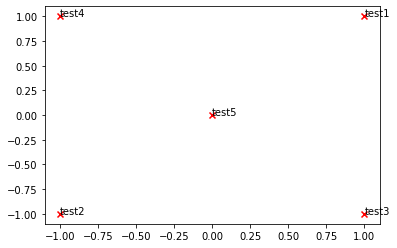

--------------------------------------------------------------------------------


In [13]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

Running Truncated SVD over 8185 words...
Done.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


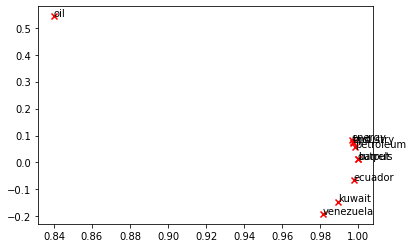

In [14]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

In [15]:
# Download Google news vector
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz

--2020-06-07 08:24:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.19.59
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.19.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.6MB/s    in 99s     

2020-06-07 08:26:30 (15.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

gzip: GoogleNews-vectors-negative300.bin already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [0]:
# !gunzip GoogleNews-vectors-negative300.bin.gz

In [16]:
!ls

GoogleNews-vectors-negative300.bin     sample_data
GoogleNews-vectors-negative300.bin.gz


In [0]:
# Fill this variable with the path to your downloaded and unzipped embeddings (`GoogleNews-vectors-negative300.bin` file).
#
# For Windows users place the `GoogleNews-vectors-negative300.bin` file in your conda environment's installation of gensim:
# `envs/{conda_env_name}/lib/site-packages/gensim/test/test_data`
# 
# For Mac/Linux users, you can place the `GoogleNews-vectors-negative300.bin` file anywhere on your machine.
# 

embeddings_fp = "/content/GoogleNews-vectors-negative300.bin"

In [0]:
def load_word2vec(embeddings_fp=embeddings_fp):
    """ Load Word2Vec Vectors
        Param:
            embeddings_fp (string) - path to .bin file of pretrained word vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
                This is the KeyedVectors format: https://radimrehurek.com/gensim/models/deprecated/keyedvectors.html
    """
    embed_size = 300
    print("Loading 3 million word vectors from file...")
    wv_from_bin = KeyedVectors.load_word2vec_format(datapath(embeddings_fp), binary=True)
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [19]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

Loading 3 million word vectors from file...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loaded vocab size 3000000


In [0]:
def get_matrix_of_vectors(wv_from_bin):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    words = list(wv_from_bin.vocab.keys())
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [0]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Putting 3000000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 3000000 words...


In [1]:
!git clone https://github.com/youngmihuang/cs224n_exercise.git

Cloning into 'cs224n_exercise'...
remote: Enumerating objects: 189, done.
remote: Total 189 (delta 0), reused 0 (delta 0), pack-reused 189
Receiving objects: 100% (189/189), 52.88 MiB | 10.44 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Checking out files: 100% (114/114), done.


In [6]:
! ls cs224n_exercise/*

cs224n_exercise/README.md

cs224n_exercise/assignment1:
exploring_word_vectors.ipynb  exploring_word_vectors.pdf  README.txt

cs224n_exercise/assignment2:
a2.pdf		       env.yml		run.py	utils	     word_vectors.png
collect_submission.sh  get_datasets.sh	sgd.py	word2vec.py

cs224n_exercise/assignment3:
a3.pdf		       data		parser_transitions.py  utils
collect_submission.sh  parser_model.py	run.py

cs224n_exercise/assignment4:
a4.pdf		       local_env.yml	    run.sh
collect_submission.sh  model_embeddings.py  sanity_check_en_es_data
en_es_data	       nmt_model.py	    sanity_check.py
gpu_requirements.txt   README.md	    utils.py
__init__.py	       run.py		    vocab.py

cs224n_exercise/assignment5:
a5.pdf

cs224n_exercise/images:
02_result_naiveGrad.png  02_result_negSamplingGrad.png


In [13]:
!cat cs224n_exercise/assignment3/parser_model.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CS224N 2018-19: Homework 3
parser_model.py: Feed-Forward Neural Network for Dependency Parsing
Editor: Youngmi Huang
"""
import pickle
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

class ParserModel(nn.Module):
    """ Feedforward neural network with an embedding layer and single hidden layer.
    The ParserModel will predict which transition should be applied to a
    given partial parse configuration.

    PyTorch Notes:
        - Note that "ParserModel" is a subclass of the "nn.Module" class. In PyTorch all neural networks
            are a subclass of this "nn.Module".
        - The "__init__" method is where you define all the layers and their respective parameters
            (embedding layers, linear layers, dropout layers, etc.).
        - "__init__" gets automatically called when you create a new instance of your class, e.g.
            when you write "m = ParserModel()".
        - 

In [0]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CS224N 2018-19: Homework 3
parser_model.py: Feed-Forward Neural Network for Dependency Parsing
Editor: Youngmi Huang
"""
import pickle
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

class ParserModel(nn.Module):
    """ Feedforward neural network with an embedding layer and single hidden layer.
    The ParserModel will predict which transition should be applied to a
    given partial parse configuration.

    PyTorch Notes:
        - Note that "ParserModel" is a subclass of the "nn.Module" class. In PyTorch all neural networks
            are a subclass of this "nn.Module".
        - The "__init__" method is where you define all the layers and their respective parameters
            (embedding layers, linear layers, dropout layers, etc.).
        - "__init__" gets automatically called when you create a new instance of your class, e.g.
            when you write "m = ParserModel()".
        - Other methods of ParserModel can access variables that have "self." prefix. Thus,
            you should add the "self." prefix layers, values, etc. that you want to utilize
            in other ParserModel methods.
        - For further documentation on "nn.Module" please see https://pytorch.org/docs/stable/nn.html.
    """
    def __init__(self, embeddings, n_features=36,
        hidden_size=200, n_classes=3, dropout_prob=0.5):
        """ Initialize the parser model.

        @param embeddings (Tensor): word embeddings (num_words, embedding_size)
        @param n_features (int): number of input features
        @param hidden_size (int): number of hidden units
        @param n_classes (int): number of output classes
        @param dropout_prob (float): dropout probability
        """
        super(ParserModel, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size = embeddings.shape[1]
        self.hidden_size = hidden_size
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))


        ### YOUR CODE HERE (~5 Lines)
        ### TODO:
        ###     1) Construct `self.embed_to_hidden` linear layer, initializing the weight matrix
        ###         with the `nn.init.xavier_uniform_` function (without any gain)
        ###     2) Construct `self.dropout` layer.
        ###     3) Construct `self.hidden_to_logits` linear layer, initializing the weight matrix
        ###         with the `nn.init.xavier_uniform_` function (without any gain)
        ###
        ### Note: Here, we use Xavier Uniform Initialization for our Weight initialization.
        ###         It has been shown empirically, that this provides better initial weights
        ###         for training networks than random uniform initialization.
        ###         For more details checkout this great blogpost:
        ###             http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization 
        ### Hints:
        ###     - After you create a linear layer you can access the weight
        ###       matrix via:
        ###         linear_layer.weight
        ###
        ### Please see the following docs for support:
        ###     Linear Layer: https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        ###     Xavier Init: https://pytorch.org/docs/stable/nn.html#torch.nn.init.xavier_uniform_
        ###     Dropout: https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout

        self.embed_shapes = embeddings.shape
        self.embed_to_hidden = nn.Linear(self.embed_size * self.n_features, self.hidden_size)
        nn.init.xavier_uniform_(self.embed_to_hidden.weight)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.hidden_to_logits = nn.Linear(self.hidden_size, n_classes)
        nn.init.xavier_uniform_(self.hidden_to_logits.weight)
        ### END YOUR CODE

    def embedding_lookup(self, t):
        """ Utilize `self.pretrained_embeddings` to map input `t` from input tokens (integers)
            to embedding vectors.

            PyTorch Notes:
                - `self.pretrained_embeddings` is a torch.nn.Embedding object that we defined in __init__
                - Here `t` is a tensor where each row represents a list of features. Each feature is represented by an integer (input token).
                - In PyTorch the Embedding object, e.g. `self.pretrained_embeddings`, allows you to
                    go from an index to embedding. Please see the documentation (https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding)
                    to learn how to use `self.pretrained_embeddings` to extract the embeddings for your tensor `t`.

            @param t (Tensor): input tensor of tokens (batch_size, n_features)

            @return x (Tensor): tensor of embeddings for words represented in t
                                (batch_size, n_features * embed_size)
        """
        ### YOUR CODE HERE (~1-3 Lines)
        ### TODO:
        ###     1) Use `self.pretrained_embeddings` to lookup the embeddings for the input tokens in `t`.
        ###     2) After you apply the embedding lookup, you will have a tensor shape (batch_size, n_features, embedding_size).
        ###         Use the tensor `view` method to reshape the embeddings tensor to (batch_size, n_features * embedding_size)
        ###
        ### Note: In order to get batch_size, you may need use the tensor .size() function:
        ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.size
        ###
        ###  Please see the following docs for support:
        ###     Embedding Layer: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        ###     View: https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

        t_embed = self.pretrained_embeddings(t)
        shapes = t_embed.size()
        x = t_embed.view(shapes[0], -1)
        ### END YOUR CODE
        return x


    def forward(self, t):
        """ Run the model forward.

            Note that we will not apply the softmax function here because it is included in the loss function nn.CrossEntropyLoss

            PyTorch Notes:
                - Every nn.Module object (PyTorch model) has a `forward` function.
                - When you apply your nn.Module to an input tensor `t` this function is applied to the tensor.
                    For example, if you created an instance of your ParserModel and applied it to some `t` as follows,
                    the `forward` function would called on `t` and the result would be stored in the `output` variable:
                        model = ParserModel()
                        output = model(t) # this calls the forward function
                - For more details checkout: https://pytorch.org/docs/stable/nn.html#torch.nn.Module.forward

        @param t (Tensor): input tensor of tokens (batch_size, n_features)

        @return logits (Tensor): tensor of predictions (output after applying the layers of the network)
                                 without applying softmax (batch_size, n_classes)
        """

        ###  YOUR CODE HERE (~3-5 lines)
        ### TODO:
        ###     1) Apply `self.embedding_lookup` to `t` to get the embeddings
        ###     2) Apply `embed_to_hidden` linear layer to the embeddings
        ###     3) Apply relu non-linearity to the output of step 2 to get the hidden units.
        ###     4) Apply dropout layer to the output of step 3.
        ###     5) Apply `hidden_to_logits` layer to the output of step 4 to get the logits.
        ###
        ### Note: We do not apply the softmax to the logits here, because
        ### the loss function (torch.nn.CrossEntropyLoss) applies it more efficiently.
        ###
        ### Please see the following docs for support:
        ###     ReLU: https://pytorch.org/docs/stable/nn.html?highlight=relu#torch.nn.functional.relu
        
        x = self.embedding_lookup(t)
        x = self.embed_to_hidden(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        logits = self.hidden_to_logits(x)
        ### END YOUR CODE
        return logits

